In [1]:
# Importação de bibliotecas básicas para a Introdução.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
from wordcloud import WordCloud

pd.options.display.max_colwidth = 100

# Introdução ao Problema

Neste desafio, queremos desenvolver métodos de classificação para identificar se uma review de um produto é positiva ou negativa, baseados na nota de 1 a 5 dada pelo usuário e o texto da review.

Para alcançar esse objetivo, diversas abordagens são possíveis, algumas simples, como apenas considerando a nota, e outras mais complexas, como utilizar modelos de Análise de Sentimento sobre o texto das reviews.

Primeiro, vamos dar uma olhada nos banco de dados a nossa disposição.

In [2]:
df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS, "olistbr/brazilian-ecommerce", "olist_order_reviews_dataset.csv")

print(df.head())

                          review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                                                                                review_comment_message  \
0                                                                                                  NaN   
1                                                                                                  NaN   
2 

Vamos primeiro fazer uma pequena análise exploratória dos nossos dados. Podemos começar plotando um histograma das notas.

<Axes: xlabel='review_score', ylabel='Count'>

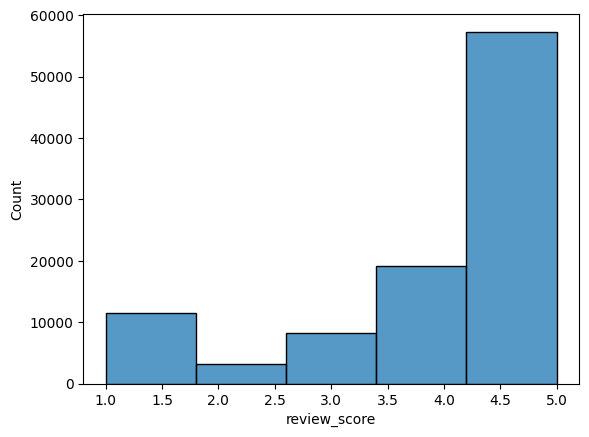

In [3]:
sns.histplot(df['review_score'], bins=5)

# Análise das Notas das Reviews

Com o dataframe em mãos, podemos partir para a primeira abordagem que proponho, utilizando puramente as notas das reviews. Isso pode tanto servir como uma análise básica por si só, quanto será necessário para termos labels para treinar nosso modelo de Análise de Sentimento na etapa mais avançada.

Em geral, é seguro considerar que notas 1 e 2 caracterizam reviews negativas, 3 caracteriza uma avaliação neutra, e 4 e 5 são atribuidas a reviews positivas. No entanto, essa abordagem nunca será 100% precisa, pois a nota que cada indivíduo dá para uma avaliação é altamente subjetiva. Existem pessoas que de fato atribuem uma nota 3 à um produto mediano, mas neste mesmo dataframe é possível encontrar reviews tanto positivas quanto negativas com notas 3. Exemplos abaixo:

In [5]:
review_positiva = df[df['review_id'] == '4656b8ed41c17f6be05e911e211ecd8f'].copy()
review_negativa = df[df['review_id'] == 'ef9ef383ff6625e8e118db388ad3420d'].copy()

print(f"Review positiva de Nota 3: \n Título: {review_positiva['review_comment_title'].to_string(index=False)} \n Mensagem: {review_positiva['review_comment_message'].to_string(index=False)}")
print()
print(f"Review negativa de Nota 3: \n Título: {review_negativa['review_comment_title'].to_string(index=False)} \n Mensagem: {review_negativa['review_comment_message'].to_string(index=False)}")

Review positiva de Nota 3: 
 Título: recomendo 
 Mensagem: Comecei a usar agora 

Review negativa de Nota 3: 
 Título: Insatisfeito 
 Mensagem: No site o produto parece ter melhor qualidade de material e acabamento.



Tendo isso em mente, se quisermos ser mais precisos, seria mais adequado classificar a nota 3 como "Inconclusiva", dado que tais inconsistências são frequentes.

Seguindo em frente, podemos então adicionar uma coluna "review_label" no dataframe, que terá valor 0 se a review tiver uma nota negativa (1 ou 2), e valor 1 se a review tiver uma nota positiva (4 ou 5).

In [6]:
def categorize_polarity(score):
  if score >= 4:
    return 1
  elif score <= 2:
    return 0
  else:
    return np.nan

df['review_label'] = df['review_score'].apply(categorize_polarity)

Vamos também ver uma pie chart das nossas novas labels, junto de seus valores absolutos, para visualizar o que obtivemos.

Positivas: 76470 
Negativas: 14575


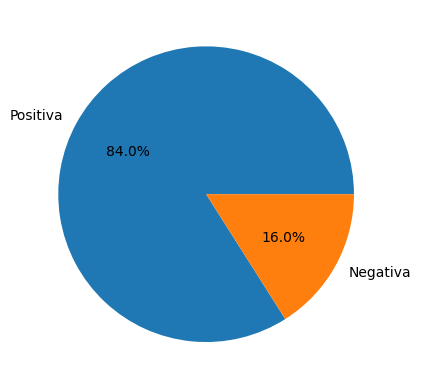

In [7]:
print(f"Positivas: {df['review_label'].value_counts()[1]} \nNegativas: {df['review_label'].value_counts()[0]}")

plt.pie(df['review_label'].value_counts(), labels=['Positiva', 'Negativa'], autopct='%1.1f%%')
plt.show()

Isso por si só já seria uma maneira de classificar as reviews. No entanto, obviamente não estamos satisfeitos com isso. Esse método, na verdade, é apenas uma etapa preparatória para o que vamos começar em seguida, utilizando um modelo de Inteligência Artificial de Análise de Sentimento para percorrer as reviews.

# Modelo de Análise Sentimental

Tendo classificado as reviews em positiva ou negativa, podemos partir para a implementação de um modelo básico de Análise Sentimental utilizando transformadores. O modelo escolhido para essa tarefa é o *BERTimbau*, por ser um modelo conhecido e robusto para NLP em português.

## Etapa 1: Pré-Processamento

Primeiramente, precisamos pré-processamento dos dados para essa tarefa específica. Realizaremos as seguintes etapas:

- Limpar e formatar o texto para melhor interpretação pelo modelo.
- Criação do nosso Dataset, Dataloaders e Tokenização.

Vamos começar realizando a formatação básica das nossas reviews.

Primeiro, removemos as reviews sem label, pois serão inúteis no treinamento. Em seguida, concatenamos o título e o texto de cada review em uma nova coluna, pois ambos possuem informações importantes para o nosso modelo.

Em seguida, removemos as reviews que não tem texto.

In [8]:
df = df[['review_comment_title', 'review_comment_message', 'review_label']].dropna(subset=['review_label']) # Removemos reviews sem label positiva ou negativa (Nota 3)
df['full_review'] = df['review_comment_title'].fillna('') + ' ' + df['review_comment_message'].fillna('') # Concatenando o título e o texto da review.
df = df[df['full_review'] != ' '] # Removendo reviews que não possuem texto.

In [9]:
# Convertendo emojis em texto para poderem ser interpretados pelo modelo mais facilmente.

import emoji
import re

def limpa_texto(texto):
  texto = emoji.demojize(texto, language='pt')
  texto = texto.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ') # Removendo caracteres como quebra linhas e tabs, caso estejam presentes.
  texto = re.sub(r'\s+', ' ', texto).strip() #
  return texto

df['full_review'] = df['full_review'].apply(limpa_texto)

Agora, precisamos definir e baixar o nosso tokenizer. Utilizando o nome do modelo no Hugging Face Hub, conseguimos extrair o tokenizer a partir da biblioteca `transformer`. O tokenizer é uma função que transforma nosso texto em *tokens* e os mapeia em um vocabulário para que possam ser acessados e interpretados pelo nosso modelo.

In [ ]:
from transformers import AutoTokenizer

MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Em seguida, definimos a nossa classe `ReviewDataset`. Essa etapa é necessária para que nossos dados estejam em um formato fácil e eficiente de serem acessados pelo nosso modelo.

Cada elemento da classe guarda um grupo de reviews, quando o nosso modelo acessar um item do dataset, apenas aquele item será tokenizado e fornecido no formato certo para o modelo. Isso garante que o processamento intenso ocorra apenas quando necessário e para a review que está sendo utilizada.

In [11]:
# Definindo nossa classe de Dataset para que os dados estejam no formato adequado para o modelo.

import torch

class ReviewDataset(torch.utils.data.Dataset):

  def __init__(self, texts, labels, tokenizer, max_len):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, item):
    text = str(self.texts[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
    )

    return {
        'review_text': text,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'label': torch.tensor(label, dtype=torch.long)
    }

E para finalizar nosso pré-processamento, iremos separar nossos dados em um split de treino e um split de validação. É importante que eles estejam totalmente separados para que nossa validação do modelo seja adequada. Neste caso, separei 80% dos dados para treino, e 20% para validação.

Em seguida, definimos nossos `DataLoaders`, que são funções responsáveis por enviar nossos dados em *batches* para serem processados. Defini `BATCH_SIZE` como 32 por ser um valor padrão para atingir boa precisão. Batches maiores podem utilizar mais memória da GPU para ter tempos de processamento menores, mas acabam sacrificando precisão do modelo.

In [12]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

MAX_LEN = 256
BATCH_SIZE = 32

df_train, df_val = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['review_label']
)

train_dataset = ReviewDataset(
    texts=df_train['full_review'].to_numpy(),
    labels=df_train['review_label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = ReviewDataset(
    texts=df_val['full_review'].to_numpy(),
    labels=df_val['review_label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4
)

E com isso, nosso pré-processamento dos dados está finalizado. Nossos dados agora estão:
- Limpos e bem formatados.
- Tokenizados de acordo com o vocabulário do nosso modelo escolhido, BERTimbau.
- Organizados em DataLoaders, prontos para serem enviados pro treinamento.

## Etapa 2: Treinamento

Agora, iniciaremos a parte mais importante, o treinamento do nosso modelo. Nessa etapa, iremos inicializar o modelo, nossos *otimizador* e *scheduler*, e por fim, nossas funções centrais `train_epoch` e `eval_model`. Então, tudo será utilizado no nosso loop de treinamento, que percorrerá pelas nossas `EPOCHS`, trainando o modelo e avaliando-o a cada passo.

In [13]:
device = torch.device("cuda") # Especificamos que o nosso modelo irá utilizar a GPU.

Começamos inicializando nosso `model` a partir do modelo que já haviamos escolhido, o *BERTimbau*.

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, # Já haviamos definido o nome do modelo antes.
    num_labels=2, # Classificação binária.
    output_attentions=False,
    output_hidden_states=False
)

model = model.to(device)

Em seguida, selecionamos nossos números de `EPOCHS` e `learning_rate`. Defini 4 épocas para atingir boa precisão, e uma taxa de aprendizagem padrão de $2 \cdot 10^{-5}$.  `optimizer` e `scheduler`. Para o otimizador, que é a função/método de otimização não-linear responsável pelo ajuste de pesos da rede neural, escolhi o `AdamW`. Já nosso agendador irá controlar o tamanho do passo de aprendizagem, dando passos maiores no início e diminuindo gradualmente.

In [15]:
from transformers import Adafactor, get_linear_schedule_with_warmup

EPOCHS = 4
learning_rate = 2e-5

optimizer = Adafactor(model.parameters(), lr=learning_rate, relative_step=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Agora, definimos duas funções.
- `train_epoch`: Executa uma época de treinamento.
- `eval_model`: Avalia o desempenho do modelo no conjunto de validação.

In [16]:
from sklearn.metrics import accuracy_score, f1_score

def train_epoch(model, data_loader, optimizer, device, scheduler):
  model = model.train() # Inicia o modo de treinamento.
  losses_list = []

  for d in data_loader: # Percorre cada batch do nosso DataLoader.
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["label"].to(device)

    outputs = model( # Passa as entradas pelo modelo e obtém os resultados.
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=labels
    )

    loss = outputs.loss # Extrai a função perda do teste.
    losses_list.append(loss.item())

    loss.backward() # Backpropagation.

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Limitamos o tamanho máximo dos gradientes para a otimização não explodir.

    optimizer.step() # Dá passos com o optimizer e scheduler para atualizar os pesos
    scheduler.step()

    optimizer.zero_grad() # Zera os gradientes para o próximo passo.

  return np.mean(losses_list) # Vamos retornar a média das perdas para visualizarmos o desempenho do treino.


def eval_model(model, data_loader, device):
  model = model.eval() # Iniciamos o modo de avaliação

  losses_list = [] # Listas para guardar os resultados.
  preds_list = []
  labels_list = []

  with torch.no_grad(): # Desativamos o cálculo de gradientes pois não estamos treinando.
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      label = d["label"].to(device)

      outputs = model( # Passamos entradas pelo modelo.
          input_ids=input_ids,
          attention_mask=attention_mask,
          labels=label
      )

      loss = outputs.loss # Retiramos as informações importantes para avaliação.
      logits = outputs.logits
      losses_list.append(loss.item())

      preds = torch.argmax(logits, dim=1).cpu().numpy()
      labels_np = label.cpu().numpy()

      preds_list.extend(preds)
      labels_list.extend(labels_np)

  return np.mean(losses_list), accuracy_score(labels_list, preds_list), f1_score(labels_list, preds_list, average='weighted') # Retornamos métricas importantes.

Por fim, realizamos o loop de treinamento e avaliação do nosso modelo.

In [17]:
best_acc = 0 # Inicializamos essa variável que será atualizada conforme a precisão for aumentando.

for epoch in range(EPOCHS): # Loop que realizará o teste e avaliação para cada época.
  print(f'- Epoch {epoch+1}/{EPOCHS}')

  train_loss = train_epoch(model, train_data_loader, optimizer, device, scheduler) # Realizamos um treinamento.

  print(f'Training Loss: {train_loss}')

  val_loss, val_acc, val_f1 = eval_model(model, val_data_loader, device) # Realizamos uma avaliação

  print(f'Validation Loss: {val_loss} \nValidation Acc: {val_acc} \nValidation_F1: {val_f1}')

  if val_acc > best_acc: # Salvamos o melhor modelo que obtivemos. Não necessariamente o modelo sempre melhorará, por isso é importante checar se a precisão aumentou.
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_acc = val_acc

- Epoch 1/4
Training Loss: 0.37030093233075334
Validation Loss: 0.18164978235655901 
Validation Acc: 0.9415077435044157 
Validation_F1: 0.9419867455401607
- Epoch 2/4
Training Loss: 0.17865486020944868
Validation Loss: 0.16033332336465922 
Validation Acc: 0.9471393830794829 
Validation_F1: 0.9474659570207622
- Epoch 3/4
Training Loss: 0.16269879158635833
Validation Loss: 0.15760679495882016 
Validation Acc: 0.9482913093562012 
Validation_F1: 0.9485543027331372
- Epoch 4/4
Training Loss: 0.15730557309133797
Validation Loss: 0.15660026479436426 
Validation Acc: 0.949187252015871 
Validation_F1: 0.9494686368917173


Assim, terminamos de construir o modelo de Análise de Sentimento, que em sua validação final obteve aproximadamente 0.95 tanto de F1 Score quanto de Precisão, o que indica excelente desempenho. Caso tal modelo fosse ser utilizado em uma aplicação real, poderíamos a partir daqui realizar inferências em datasets que não possuem labels, por exemplo, reviews que não possuem uma nota associada.

# Bônus: Aspect Based Sentiment Analysis (ABSA)

Para a solução do "bônus supervalorizado" mencionado, seria necessária a implementação de um modelo de ABSA, que identificaria diferentes aspectos dentro de cada review e realizaria análise de sentimento sobre cada um.

Tal tarefa é de um grau de complexidade mais elevado quando comparado ao modelo simples de Análise Sentimental que preparei acima. Infelizmente, devido à compromissos acadêmicos relacionados à finalização e apresentação do meu projeto de Iniciação Científica, que coincidiu com o período deste desafio, não serei capaz de incluir a resolução completa.

No entanto, baseado nos estudos que fiz para este desafio, irei incluir um outline de como eu resolveria esse problema.

Para implementar a ABSA, é necessário construir dois modelos de NLP:
- **ASPECT EXTRACTION:** Um responsável por percorrer as reviews e identificar tanto os aspectos presentes no texto e quais partes do texto se referem a qual aspecto.
- **ASPECT SENTIMENT CLASSIFICATION:** Um modelo de Análise de Sentimento que percorreria o texto fragmentado pelo primeiro modelo e classificaria o sentimento relacionado a cada aspecto.

Como labels baseados nos aspectos não existem no nosso dataframe, para cada um dos modelos seria necessário manualmente rotular parte dos dados com relação aos seus aspectos e o sentimento relacionado a eles, para então treinar o modelo a partir disso.